In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import random
import shutil
import numpy as np
import radiomics
from radiomics import featureextractor
import SimpleITK as sitk

In [ ]:
kinds = ['HGG','LGG']
#这个是特征处理配置文件，具体可以参考pyradiomics官网
para_path = 'yaml/MR_1mm.yaml'

extractor = featureextractor.RadiomicsFeatureExtractor(para_path)
dirs = 'data/MyData/'

for kind in kinds:
    print("{}:开始提取特征".format(kind))
    features_dict = dict()
    df = pd.DataFrame()
    path = dirs + kind
    # 使用配置文件初始化特征抽取器
    for index, folder in enumerate( os.listdir(path)):
        for f in os.listdir(os.path.join(path, folder)):
            if 't1ce' in f:
                ori_path = os.path.join(path,folder, f)
                break
        lab_path = ori_path.replace('t1ce','seg')
        features = extractor.execute(ori_path,lab_path)  #抽取特征
        #新增一列用来保存病例文件夹名字
        features_dict['index'] = folder
        for key, value in features.items():  #输出特征
            features_dict[key] = value
        df = df.append(pd.DataFrame.from_dict(features_dict.values()).T,ignore_index=True)
        print(index)
    df.columns = features_dict.keys()
    df.to_csv('csv/' +'{}.csv'.format(kind),index=0)
    print('Done')
print("完成")

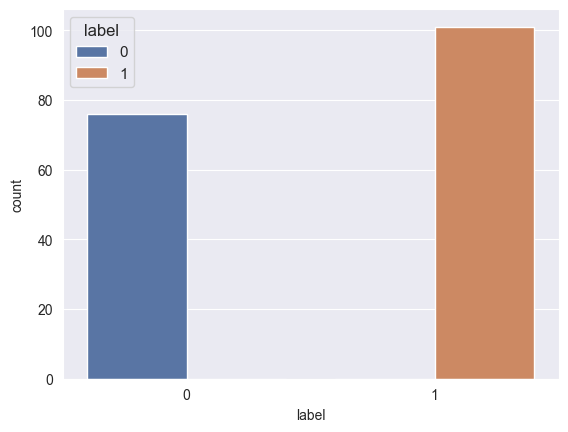

1    101
0     76
Name: label, dtype: int64


In [3]:
hgg_data = pd.read_csv('csv/HGG.csv')
lgg_data = pd.read_csv('csv/LGG.csv')

hgg_data.insert(1,'label', 1) #插入标签
lgg_data.insert(1,'label', 0) #插入标签

#因为有些特征是字符串，直接删掉
cols=[x for i,x in enumerate(hgg_data.columns) if type(hgg_data.iat[1,i]) == str]
cols.remove('index')
hgg_data=hgg_data.drop(cols,axis=1)
cols=[x for i,x in enumerate(lgg_data.columns) if type(lgg_data.iat[1,i]) == str]
cols.remove('index')
lgg_data=lgg_data.drop(cols,axis=1)

#再合并成一个新的csv文件。
total_data = pd.concat([hgg_data, lgg_data])
total_data.to_csv('csv/TotalOMICS.csv',index=False)

#简单查看数据的分布
fig, ax = plt.subplots()
sns.set()
ax = sns.countplot(x='label',hue='label',data=total_data)
plt.show()
print(total_data['label'].value_counts())

In [ ]:
import pandas as pd
def compare(data1,  data2,filename):
    # 读取两个表
    dt1 = pd.read_csv(data1,encoding='utf-8')
    dt2 = pd.read_csv(data2,encoding='gb18030')
    dt2.head()
    df = pd.DataFrame()
    dt1_name = dt1['index'].values.tolist()
    dt2_name = dt2['index'].values.tolist()

    for i in dt1_name:
        if i in dt2_name:
            dt2_row = dt2.loc[dt2['index'] == i]
            df = df.append(dt2_row)
    df.to_csv('./csv/'+filename+'.csv',header=True,index=False,encoding="utf_8_sig")
data_train= "./csv/trainOmics.csv"
data_test = "./csv/testOmics.csv"
data_clinic= "./csv/TotalClinic.csv"
compare(data_train,data_clinic,"trainClinic")
compare(data_test,data_clinic,"testClinic")

## 先做T检验，再做Lasso回归进行对特征筛选，再逻辑回归建模

In [17]:
# T检验
from scipy.stats import levene, ttest_ind
tData = pd.read_csv('./csv/trainOmics.csv')

df0 = tData[tData['label'].isin([0])]  # 将tData中label为0的行挑选出来
df1 = tData[tData['label'].isin([1])]  # 将tData中label为1的行挑选出来

counts = 0
columns_index =[]
for column_name in tData.columns[2:]:
    if levene(df1[column_name], df0[column_name])[1] > 0.05:
        if ttest_ind(df1[column_name],df0[column_name],equal_var=True)[1] < 0.05:
            columns_index.append(column_name)
    else:
        if ttest_ind(df1[column_name],df0[column_name],equal_var=False)[1] < 0.05:
            columns_index.append(column_name)

print("筛选后剩下的特征数：{}个".format(len(columns_index)))
# print(columns_index)

# 数据只保留从T检验筛选出的特征数据，重新组合成data
if not 'label' in columns_index:
    columns_index = ['label'] + columns_index
if not 'index' in columns_index:
    columns_index = ['index'] + columns_index
df1 = df1[columns_index]
df0 = df0[columns_index]

tData = pd.concat([df1, df0])
# tData.to_csv('./csv/tData_train.csv',header=True,index=False,encoding="utf_8_sig")

/Users/kukudehui/Documents/01_编程学习/python/12_影像组学/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


筛选后剩下的特征数：562个
